# Analyze 311 dataset from NYC Department of Housing Preservation and Development

## Question 4

Can a predictive model be built for a future prediction of the possibility of complaints of the type that you have identified in response to question 1?

### 1. step

Load dataset, reduce dataset on complaints about heating and add appropriate date values

In [3]:
# Read 311 data from local file system

import pandas as pd

df_311 = pd.read_csv("fhrw-4uyv.csv", parse_dates=True)

In [4]:
# create year_month and month/year column for grouping

df_311['year_month'] = pd.to_datetime(df_311['created_date']).apply(lambda x: pd.datetime(year=x.year, month=x.month, day=1))
df_311['month'] = pd.to_datetime(df_311['created_date']).apply(lambda x: x.month)
df_311['year'] = pd.to_datetime(df_311['created_date']).apply(lambda x: x.year)

df_311.head()

,address_type,borough,city,closed_date,complaint_type,created_date,incident_address,incident_zip,latitude,location_type,longitude,resolution_description,status,street_name,unique_key,year_month,month,year
0,NaN,Unspecified,NaN,2013-01-11T15:01:56.000,HPD Literature Request,2013-01-11T13:25:34.000,NaN,NaN,NaN,NaN,NaN,The literature has been mailed. If it has not ...,Closed,NaN,24765056,2013-01-01,1,2013
1,ADDRESS,QUEENS,Queens Village,2019-03-30T08:58:02.000,PAINT/PLASTER,2018-08-11T19:19:41.000,104-34 219 STREET,11429.0,40.711539,RESIDENTIAL BUILDING,-73.735724,The Department of Housing Preservation and Dev...,Closed,219 STREET,39981834,2018-08-01,8,2018
2,ADDRESS,QUEENS,Queens Village,2019-03-30T08:58:01.000,APPLIANCE,2018-08-11T19:19:41.000,104-34 219 STREET,11429.0,40.711539,RESIDENTIAL BUILDING,-73.735724,The Department of Housing Preservation and Dev...,Closed,219 STREET,39982698,2018-08-01,8,2018
3,ADDRESS,QUEENS,Queens Village,2019-03-30T08:58:01.000,UNSANITARY CONDITION,2018-08-11T19:19:41.000,104-34 219 STREET,11429.0,40.711539,RESIDENTIAL BUILDING,-73.735724,The Department of Housing Preservation and Dev...,Closed,219 STREET,39987943,2018-08-01,8,2018
4,ADDRESS,QUEENS,Saint Albans,2019-03-30T08:58:02.000,DOOR/WINDOW,2018-10-23T19:27:06.000,116-35 195 STREET,11412.0,40.693715,RESIDENTIAL BUILDING,-73.757117,The Department of Housing Preservation and Dev...,Closed,195 STREET,40636028,2018-10-01,10,2018


In [5]:
# group by complaint type and year_month / month

df_311_complaints_year_month = df_311.groupby(['complaint_type', 'year_month']).size().reset_index()
df_311_complaints_year_month.columns = ['complaint_type', 'year_month', 'count']

df_311_complaints_month = df_311.groupby(['complaint_type', 'year', 'month']).size().reset_index()
df_311_complaints_month.columns = ['complaint_type', 'year', 'month', 'count']

df_311_complaints_year_month.set_index('complaint_type', inplace=True)
df_311_complaints_year_month = df_311_complaints_year_month.pivot_table('count', index=['year_month'], columns=['complaint_type']).fillna(0)

df_311_complaints_month.set_index('complaint_type', inplace=True)
df_311_complaints_month = df_311_complaints_month.pivot_table('count', index=['year','month'], columns=['complaint_type']).fillna(0)

df_311_complaints_month.head()

complaint_type  AGENCY  APPLIANCE  CONSTRUCTION  DOOR/WINDOW  ELECTRIC  \
year month                                                               
2010 1             0.0     1180.0          66.0          0.0    3575.0   
     2             0.0      998.0          88.0          0.0    2981.0   
     3             0.0     1217.0         113.0          0.0    3393.0   
     4             0.0     1071.0         103.0          0.0    2749.0   
     5             0.0     1012.0          97.0          0.0    2690.0   

complaint_type  ELEVATOR  FLOORING/STAIRS  GENERAL  GENERAL CONSTRUCTION  \
year month                                                                 
2010 1               0.0              0.0      0.0               12119.0   
     2               0.0              0.0      0.0                9913.0   
     3               0.0              0.0      0.0               12531.0   
     4               0.0              0.0      0.0               10179.0   
     5               0.0              0.0      0.0                9031.0   

complaint_type  HEAT/HOT WATER  ...  NONCONST  OUTSIDE BUILDING  \
year month                      ...                               
2010 1                     0.0  ...    5190.0               0.0   
     2                     0.0  ...    4277.0               0.0   
     3                     0.0  ...    5119.0               0.0   
     4                     0.0  ...    4735.0               0.0   
     5                     0.0  ...    4803.0               0.0   

complaint_type  PAINT - PLASTER  PAINT/PLASTER  PLUMBING  SAFETY  STRUCTURAL  \
year month                                                                     
2010 1                   7967.0            0.0   10720.0     0.0         0.0   
     2                   7018.0            0.0    9332.0     0.0         0.0   
     3                  10589.0            0.0   13239.0     0.0         0.0   
     4                   7940.0            0.0    8784.0     0.0         0.0   
     5                   6852.0            0.0    7492.0     0.0         0.0   

complaint_type  UNSANITARY CONDITION  VACANT APARTMENT  WATER LEAK  
year month                                                          
2010 1                           0.0               0.0         0.0  
     2                           0.0               0.0         0.0  
     3                           0.0               0.0         0.0  
     4                           0.0               0.0         0.0  
     5                           0.0               0.0         0.0  

[5 rows x 22 columns]

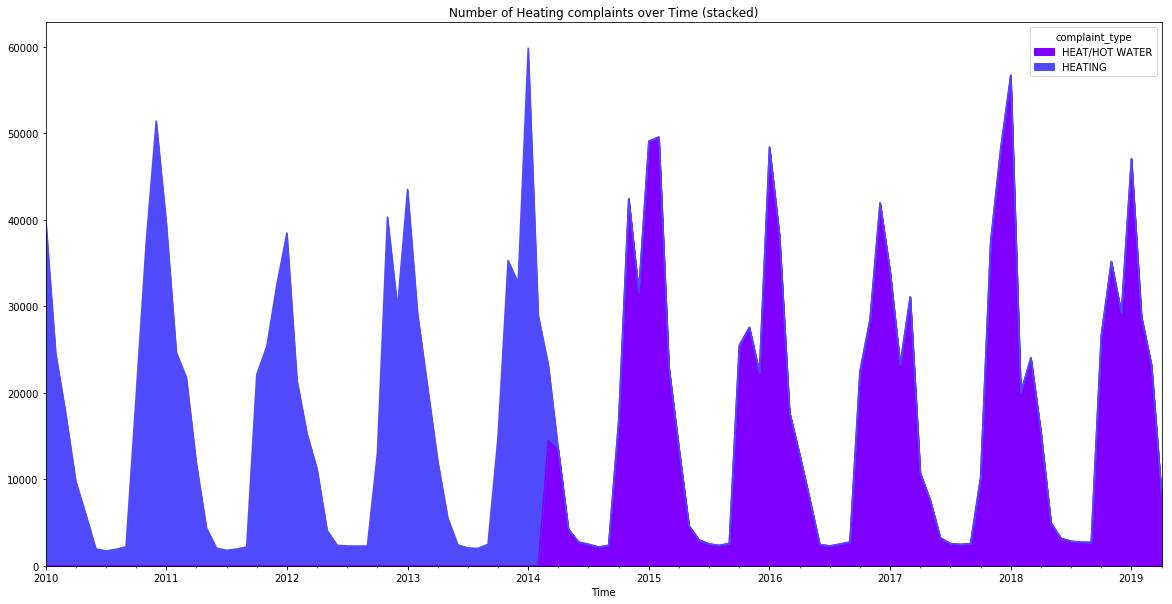

In [6]:
# 'HEATING' might have been replaced 'HEAT/HOT WATER' in 2015, so compare just these two

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline 

viridis = cm.get_cmap('rainbow', 22)
newcolors = viridis(np.linspace(0, 1, 10))

ax = df_311_complaints_year_month[['HEAT/HOT WATER', 'HEATING']].plot(kind='area', figsize=(20,10), stacked=True, color=newcolors)
ax.set_xlabel('Time')
ax.set_title('Number of Heating complaints over Time (stacked)')

plt.show()

### 2. step

Summarize complaints on month and analyze distribution.

In [7]:
df_311_complaints_heating_month = df_311_complaints_month['HEAT/HOT WATER'] + df_311_complaints_month['HEATING']
df_311_complaints_heating_month = df_311_complaints_heating_month.reset_index()
df_311_complaints_heating_month.columns = ['year', 'month', 'count']
df_311_complaints_heating_month.head()

,year,month,count
0,2010,1,40213.0
1,2010,2,24616.0
2,2010,3,17621.0
3,2010,4,9779.0
4,2010,5,5940.0


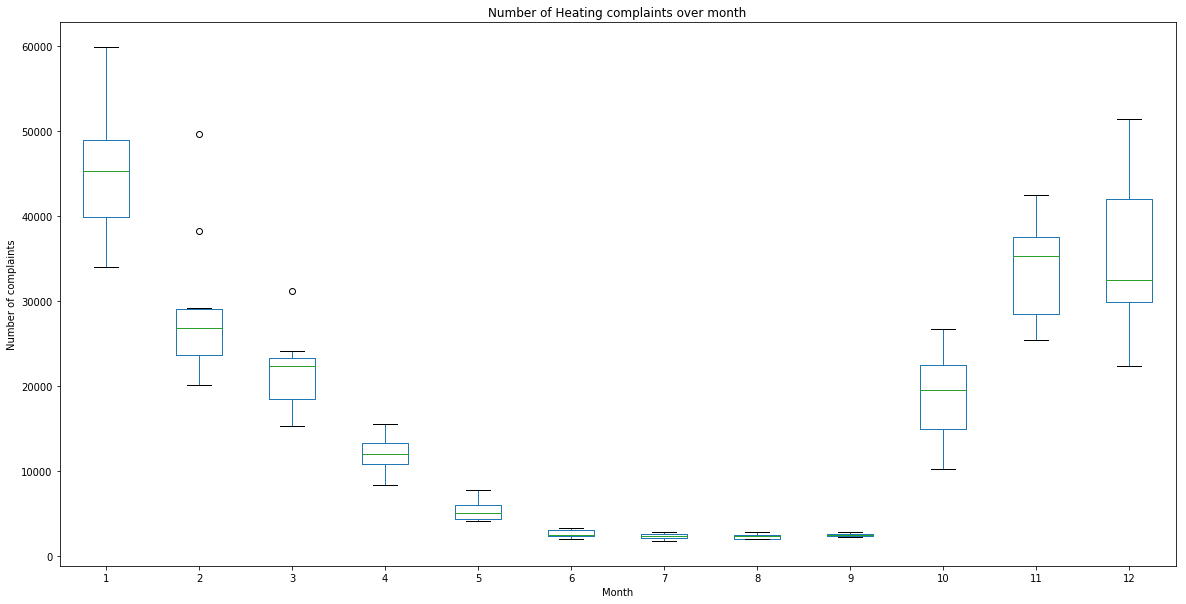

In [8]:
# visualize heating complaints over month as boxplot

df_311_complaints_heating_month_pivot = df_311_complaints_heating_month.pivot_table('count', index=['year'], columns=['month'])
df_311_complaints_heating_month_pivot.head()

ax = df_311_complaints_heating_month_pivot.plot(kind='box', by='month',figsize=(20,10))
ax.set_xlabel('Month')
ax.set_ylabel('Number of complaints')
ax.set_title('Number of Heating complaints over month')

plt.show()

In [9]:
# building averages for each calender month

df_311_complaints_heating_month_mean = df_311_complaints_heating_month.groupby(by='month').mean().reset_index()
df_311_complaints_heating_month_mean = df_311_complaints_heating_month_mean[['month', 'count']]
df_311_complaints_heating_month_mean

,month,count
0,1,45710.300000
1,2,28881.600000
2,3,21760.700000
3,4,11915.400000
4,5,5453.888889
5,6,2599.555556
6,7,2290.333333
7,8,2267.444444
8,9,2462.222222
9,10,19017.000000


### 3. step

Creating a polynomial function for distribution of complaints

In [12]:
from scipy.optimize import curve_fit

def fun2(x, Beta_1, Beta_2):
     y = Beta_1 + x*x*Beta_2
     return y

def fun3(x, Beta_1, Beta_2, Beta_3):
     y = Beta_1 + x*x*Beta_2 + x*x*x*Beta_3
     return y

def fun4(x, Beta_1, Beta_2, Beta_3, Beta_4):
     y = Beta_1 + x*x*Beta_2 + x*x*x*Beta_3 + x*x*x*x*Beta_4
     return y

def fun5(x, Beta_1, Beta_2, Beta_3, Beta_4, Beta_5):
     y = Beta_1 + x*x*Beta_2 + x*x*x*Beta_3 + x*x*x*x*Beta_4 + x*x*x*x*x*Beta_5
     return y

In [23]:
x = df_311_complaints_heating_month['month']
y = df_311_complaints_heating_month['count']

popt2, pcov2 = curve_fit(fun2, x, y)
#print the final parameters
print("Poly of order 2: beta_1 = %f, beta_2 = %f" % (popt2[0], popt2[1]))

popt3, pcov3 = curve_fit(fun3, x, y)
#print the final parameters
print("Poly of order 3: beta_1 = %f, beta_2 = %f, beta_3 = %f" % (popt3[0], popt3[1], popt3[2]))

popt4, pcov4 = curve_fit(fun4, x, y)
#print the final parameters
print("Poly of order 4: beta_1 = %f, beta_2 = %f, beta_3 = %f, beta_4 = %f" % (popt4[0], popt4[1], popt4[2], popt4[3]))

popt5, pcov5 = curve_fit(fun5, x, y)
#print the final parameters
print("Poly of order 5: beta_1 = %f, beta_2 = %f, beta_3 = %f, beta_4 = %f, beta_5 = %f" % (popt5[0], popt5[1], popt5[2], popt5[3], popt5[4]))

Poly of order 2: beta_1 = 16635.433419, beta_2 = 26.509261
Poly of order 3: beta_1 = 36065.384663, beta_2 = -1768.113244, beta_3 = 152.694797
Poly of order 4: beta_1 = 45228.598139, beta_2 = -4143.992458, beta_3 = 622.039407, beta_4 = -23.415855
Poly of order 5: beta_1 = 45332.948071, beta_2 = -4202.299409, beta_3 = 641.677728, beta_4 = -25.618519, beta_5 = 0.080697


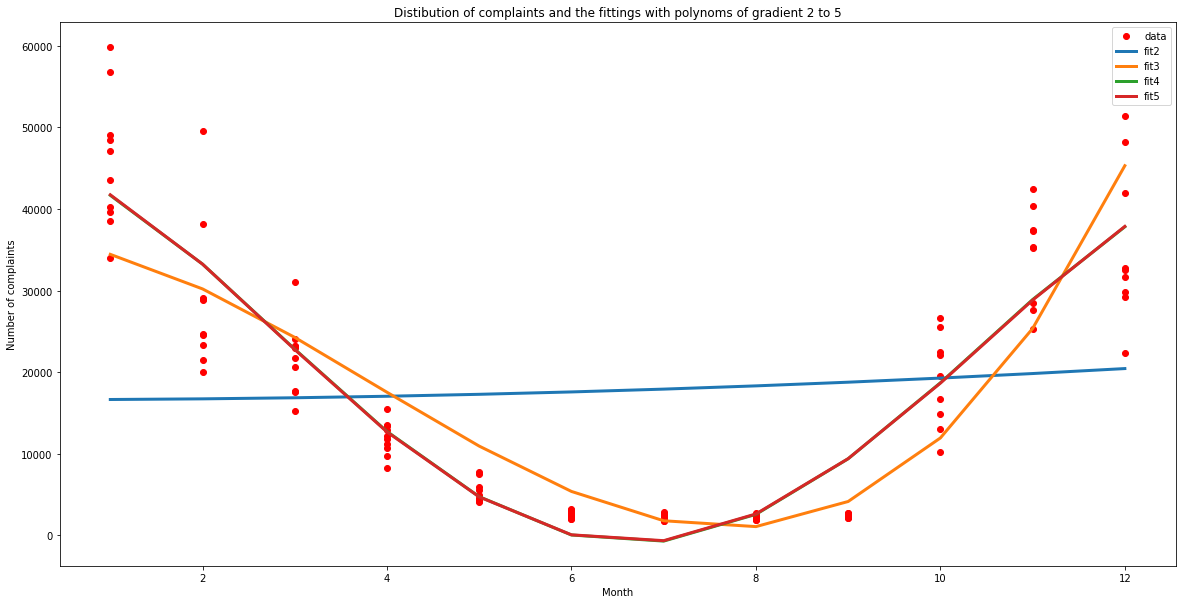

In [24]:
# visualize polys

plt.figure(figsize=(20,10))

plt.plot(x, y, 'ro', label='data')

x1 = df_311_complaints_heating_month_mean['month']
y2 = fun2(x1, *popt2)
plt.plot(x1,y2, linewidth=3.0, label='fit2')

y3 = fun3(x1, *popt3)
plt.plot(x1,y3, linewidth=3.0, label='fit3')

y4 = fun4(x1, *popt4)
plt.plot(x1,y4, linewidth=3.0, label='fit4')

y5 = fun5(x1, *popt5)
plt.plot(x1,y5, linewidth=3.0, label='fit5')

plt.legend(loc='best')
plt.ylabel('Number of complaints')
plt.xlabel('Month')
plt.title('Distibution of complaints and the fittings with polynoms of gradient 2 to 5')
plt.show()

In [25]:
# error for polys

#!pip install sklearn
from sklearn.metrics import r2_score

print("Poly of order 2:")
y2 = fun2(x, *popt2)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y2 - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y2 - y) ** 2))
print("R2-score: %.2f" % r2_score(y2 , y) )

print("\nPoly of order 3:")
y3 = fun3(x, *popt3)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y3 - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y3 - y) ** 2))
print("R2-score: %.2f" % r2_score(y3 , y) )

print("\nPoly of order 4:")
y4 = fun4(x, *popt4)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y4 - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y4 - y) ** 2))
print("R2-score: %.2f" % r2_score(y4 , y) )

print("\nPoly of order 5:")
y5 = fun5(x, *popt5)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y5 - y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y5 - y) ** 2))
print("R2-score: %.2f" % r2_score(y5 , y) )

Poly of order 2:
Mean absolute error: 13375.94
Residual sum of squares (MSE): 244685022.18
R2-score: -162.82

Poly of order 3:
Mean absolute error: 5677.60
Residual sum of squares (MSE): 61698314.48
R2-score: 0.67

Poly of order 4:
Mean absolute error: 4534.00
Residual sum of squares (MSE): 36500228.98
R2-score: 0.83

Poly of order 5:
Mean absolute error: 4533.65
Residual sum of squares (MSE): 36498216.75
R2-score: 0.83


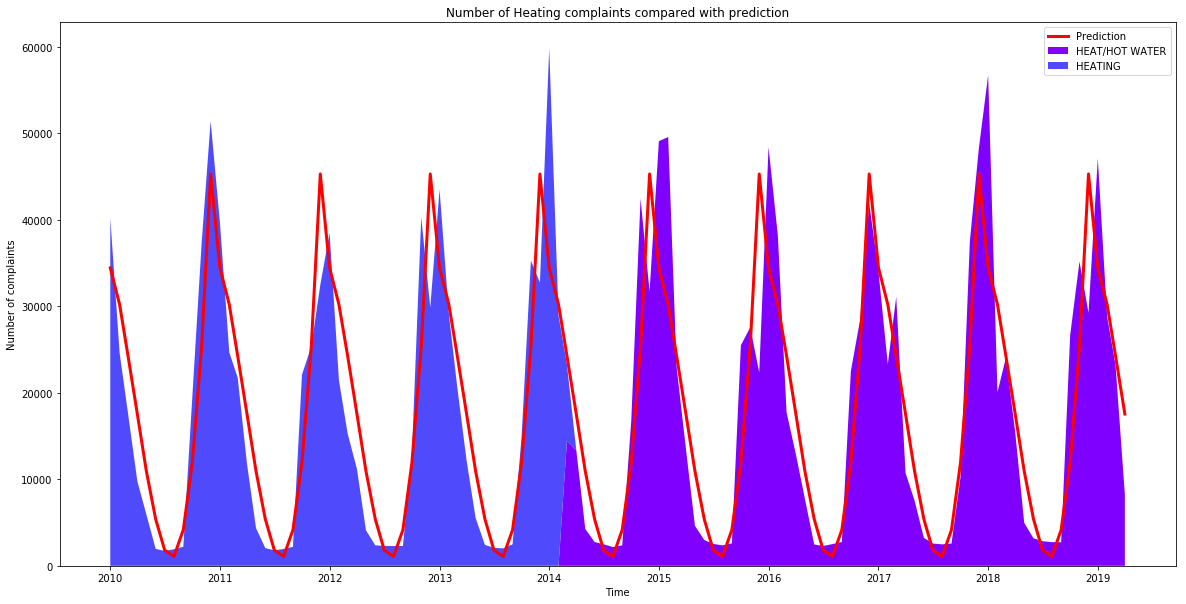

In [28]:
plt.figure(figsize=(20,10))
plt.stackplot(df_311_complaints_year_month.index, df_311_complaints_year_month['HEAT/HOT WATER'],df_311_complaints_year_month['HEATING'], 
              labels=['HEAT/HOT WATER', 'HEATING'], colors=newcolors)
plt.xlabel('Time')
plt.ylabel('Number of complaints')
plt.title('Number of Heating complaints compared with prediction')

# prediction line
yhat = []
for i in df_311_complaints_year_month.index:
    yhat.append(y3[i.month-1])

plt.plot(df_311_complaints_year_month.index, yhat, linewidth=3.0, color='red',label='Prediction')
plt.legend(loc='best')
        
plt.show()

## Result

The distibution of complaints about heating over month shows a small variance in summer times and a higher variance in winter times. This might be due to the strength of the winter and could be analyzed further. A polynomial of degree 3 is sufficient to predict the number of compaints for each month but neglects the higher variance in winter.